In [1]:
# Import some basic libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')

# Hands-on Activity 14.4: The point-predictive Distribution - Separating Epistmic and Aleatory Uncertainty

## Objectives

+ To demonstrate how epistemic from aleatory uncertainty can be separated.

## Example (Quadratic)

Let's repeat what we did above with a quadratic example.
Here are some synthetic data:

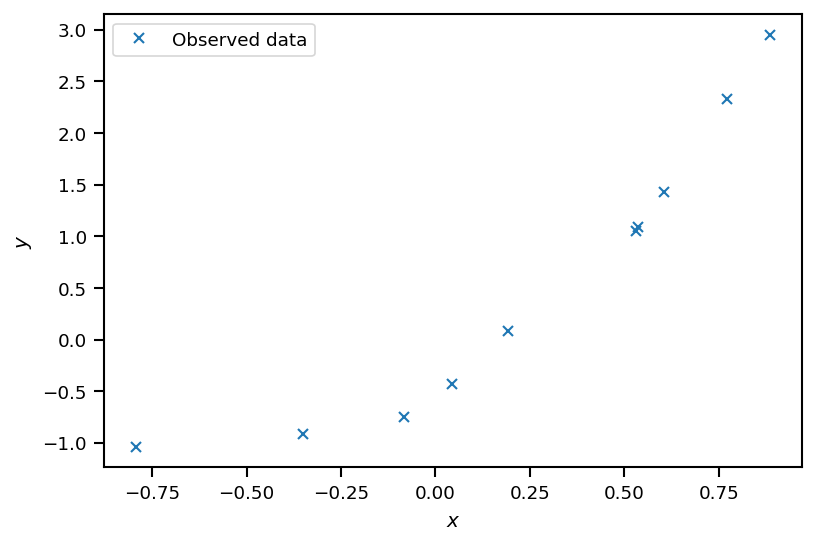

In [2]:
# How many observations we have
num_obs = 10
x = -1.0 + 2 * np.random.rand(num_obs)
w0_true = -0.5
w1_true = 2.0
w2_true = 2.0
sigma_true = 0.1
y = w0_true + w1_true * x + w2_true * x ** 2 + sigma_true * np.random.randn(num_obs)
# Let's plot the data
fig, ax = plt.subplots(dpi=150)
ax.plot(x, y, 'x', label='Observed data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

Let's also copy-paste the code from previous hands-on activities for generating the design matrix and fitting the models.

In [3]:
import scipy

def get_polynomial_design_matrix(x, degree):
    """
    Returns the polynomial design matrix of ``degree`` evaluated at ``x``.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    # Start with an empty list where we are going to put the columns of the matrix
    cols = []
    # Loop over columns and add the polynomial
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

def get_fourier_design_matrix(x, L, num_terms):
    """
    Fourier expansion with ``num_terms`` cosines and sines.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    # Loop over columns and add the polynomial
    for i in range(1, int(num_terms / 2)):
        cols.append(np.cos(2 * i * np.pi / L * x))
        cols.append(np.sin(2 * i * np.pi / L * x))
    return np.hstack(cols)
                    
def get_rbf_design_matrix(x, x_centers, ell):
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    # Loop over columns and add the polynomial
    for i in range(x_centers.shape[0]):
        cols.append(np.exp(-(x - x_centers[i]) ** 2 / ell))
    return np.hstack(cols)

def find_m_and_S(Phi, y, sigma2, alpha):
    """
    Return the posterior mean and covariance of the weights of a Bayesian linear regression problem with
    design matrix ``Phi`` observed targets ``y``, noise variance ``sigma2``
    and priors for the weights ``alpha``.
    """
    A = np.dot(Phi.T, Phi) / sigma2 + alpha * np.eye(Phi.shape[1])
    L = scipy.linalg.cho_factor(A)
    m = scipy.linalg.cho_solve(L, np.dot(Phi.T, y / sigma2))
    S = scipy.linalg.cho_solve(L, np.eye(Phi.shape[1]))
    return m, S

Here is how we fit a $7$ degree polynomial:

In [4]:
import scipy.stats as st

# Select polynomial degree and get design matrix
degree = 7
Phi = get_polynomial_design_matrix(x[:, None], degree)# Pick variance (here I am using the true one)
sigma2 = 0.1 ** 2
# Pick the regularization parameter:
alpha = 5.0
# The prior for the weights
w_prior = st.multivariate_normal(mean=np.zeros(degree+1), cov=alpha * np.eye(degree+1))
# Solve for the MAP of the weights:
m, S = find_m_and_S(Phi, y, sigma2, alpha)
# The posterior of the weights
w_post = st.multivariate_normal(mean=m, cov=S)

As we discussed in the video, it is possible to get the posterior point predictive distribution for $y$ conditioned on $\mathbf{x}$ and to separate aleatory from epistemic uncertainty.
The posterior point predictive is:
$$
s^2(\mathbf{x}) = \boldsymbol{\phi}(\mathbf{x})^T\mathbf{S}\boldsymbol{\phi}(\mathbf{x}) + \sigma^2.
$$
+ $\sigma^2$ corresponds to the measurement noise.
+ $\boldsymbol{\phi}(\mathbf{x})^T\mathbf{S}\boldsymbol{\phi}(\mathbf{x})$ is the epistemic uncertainty induced by limited data.

Here is how to visualize both of these:

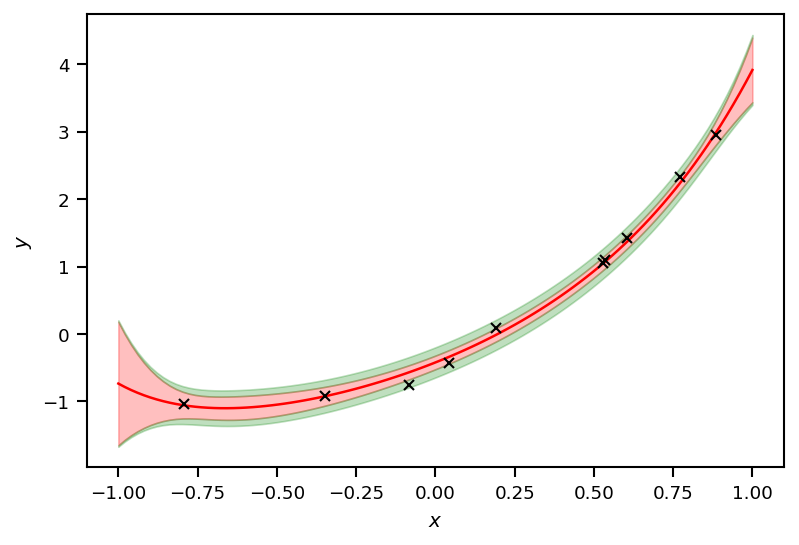

In [5]:
fig, ax = plt.subplots(dpi=150)
# Some points on which to evaluate the regression function
xx = np.linspace(-1, 1, 100)
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)
yy_mean = np.dot(Phi_xx, m)
yy_var = np.einsum('ij,jk,ik->i', Phi_xx, S, Phi_xx)
yy_measured_var = yy_var + sigma2
yy_std = np.sqrt(yy_var)
yy_measured_std = np.sqrt(yy_measured_var)
# Epistemic lower bound
yy_le = yy_mean - 2.0 * yy_std
# Epistemic upper bound
yy_ue = yy_mean + 2.0 * yy_std
# Epistemic + aleatory lower bound
yy_lae = yy_mean - 2.0 * yy_measured_std
# Episemic + aleatory upper bound
yy_uae = yy_mean + 2.0 * yy_measured_std
ax.plot(xx, yy_mean, 'r')
ax.fill_between(xx, yy_le, yy_ue, color='red', alpha=0.25)
ax.fill_between(xx, yy_lae, yy_le, color='green', alpha=0.25)
ax.fill_between(xx, yy_ue, yy_uae, color='green', alpha=0.25)
# plot the data again
ax.plot(x, y, 'kx', label='Observed data')
# The true connection between x and y
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2
# overlay the true 
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

### Questions

+ Rerun the code cells above with a very small $\alpha$. What happens?
+ Rerun he code cells above with a very big $\alpha$. What happens?
+ Fix $\alpha$ to $5$ and rerun the code cells above with a very small and the very big value for $\sigma$. What happens in each case